In [1]:
import warnings
# 忽略警告訊息
warnings.filterwarnings("ignore")
import pandas as pd

df = pd.read_csv('winequality-red.csv', sep=';')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [2]:
# 檢查是否有遺漏值
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [3]:
# 查看 quality 分布狀況
df['quality'].value_counts() 

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

由上得知3,8非常少，而5,6非常多
由於數據分布極度不均，即使模型全部預測品質是5也有很高的準確度，因此待會可嘗試處理類別不平衡情形

相關係數： [[ 1.         -0.68297819]
 [-0.68297819  1.        ]]


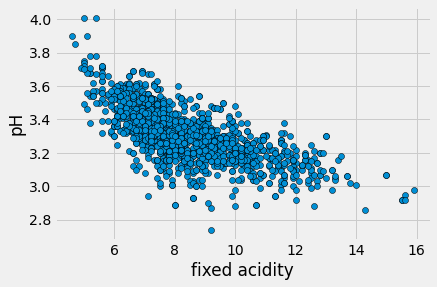

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

print('相關係數：', np.corrcoef(df['fixed acidity'], df['pH']))
plt.scatter(df['fixed acidity'], df['pH'], edgecolor='black')
plt.xlabel('fixed acidity')
plt.ylabel('pH')
plt.show()

相關係數： [[1.         0.11477672]
 [0.11477672 1.        ]]


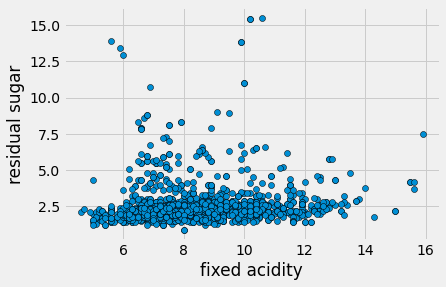

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

print('相關係數：', np.corrcoef(df['fixed acidity'], df['residual sugar']))
plt.scatter(df['fixed acidity'], df['residual sugar'], edgecolor='black')
plt.xlabel('fixed acidity')
plt.ylabel('residual sugar')
plt.show()

<AxesSubplot:>

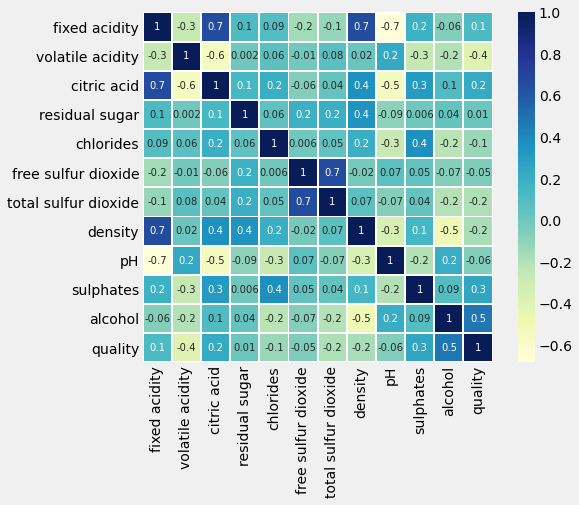

In [6]:
import seaborn as sns
_, ax = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.1g', 
            square=True, linewidths=1, cmap="YlGnBu",  
            annot_kws={'fontsize':10}, ax=ax)

一些如酒精，檸檬酸，游離二氧化硫，pH值呈正相關，紅酒品量會有所改善，
而密度，殘糖和酸度會對質量產生負面影響。

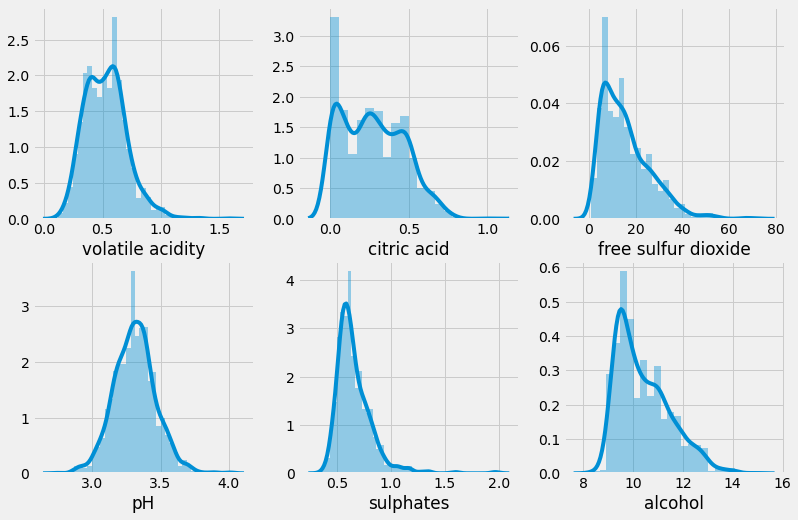

In [7]:
features = ['volatile acidity', 'citric acid', 'free sulfur dioxide', 'pH', 'sulphates', 'alcohol']

f, axes = plt.subplots(2, 3, figsize=(12, 8))
row, col = 0, 0
for i, fea in enumerate(features):
    col = i%3
    if i > 2: row = 1
    sns.distplot(df[fea], ax=axes[row, col])

In [8]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)
y_train.value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

利用 imbalanced-learn 套件平衡訓練數據的類別

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_sam, y_train_sam = ros.fit_resample(X_train, y_train)
pd.DataFrame(y_train_sam)[0].value_counts().sort_index()

Using TensorFlow backend.


3    545
4    545
5    545
6    545
7    545
8    545
Name: 0, dtype: int64

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X = df.drop(['quality'], axis=1)
y = df['quality']

# 建立管道化
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('SVM', SVC())])

paran_range = np.logspace(-4, 2, 10)
param_grid = {'SVM__C': paran_range, 
              'SVM__gamma': paran_range}
grid_s = GridSearchCV(pipe, param_grid=param_grid, 
                      cv=5, n_jobs=-1)
grid_s.fit(X_train, y_train)
print('Testing score = %.2f' % grid_s.score(X_test, y_test))
print(grid_s.best_params_)

Testing score = 0.64
{'SVM__C': 1.0, 'SVM__gamma': 0.21544346900318823}


In [11]:
grid_s.fit(X_train_sam, y_train_sam)
print('Testing score = %.2f' % grid_s.score(X_test, y_test))
print(grid_s.best_params_)

Testing score = 0.68
{'SVM__C': 100.0, 'SVM__gamma': 1.0}


In [12]:
param_grid = {'SVM__C': paran_range, 
              'SVM__gamma': paran_range, 
              'SVM__class_weight': ['balanced']}
grid_s = GridSearchCV(pipe, param_grid=param_grid, 
                      cv=5, n_jobs=-1)
grid_s.fit(X_train, y_train)
print('Testing score = %.2f' % grid_s.score(X_test, y_test))
print(grid_s.best_params_)

Testing score = 0.69
{'SVM__C': 4.641588833612772, 'SVM__class_weight': 'balanced', 'SVM__gamma': 1.0}


In [13]:
from sklearn.model_selection import cross_val_score

# 進行巢狀交叉驗證
scores = cross_val_score(grid_s, X_train, y_train, 
                         scoring='accuracy', cv=3)
print('CV accuracy (training): %.3f +/- %.3f' 
      %(np.mean(scores), np.std(scores)))
grid_s.fit(X_train, y_train)
print('Best parameters (training):', grid_s.best_params_)
grid_s.score(X_test, y_test)

CV accuracy (training): 0.622 +/- 0.007
Best parameters (training): {'SVM__C': 4.641588833612772, 'SVM__class_weight': 'balanced', 'SVM__gamma': 1.0}


0.6875